<a href="https://colab.research.google.com/github/Zuzed22/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes---Parte-2/blob/main/TelecomX_LATAM_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Misión

Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

## 🧠 Objetivos del Desafío

- Preparar los datos para el modelado (tratamiento, codificación, normalización).

- Realizar análisis de correlación y selección de variables.

- Entrenar dos o más modelos de clasificación.

- Evaluar el rendimiento de los modelos con métricas.

- Interpretar los resultados, incluyendo la importancia de las variables.

- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

In [30]:
# Importación de librerías necesarias
print("Importando librerías para Machine Learning...")

# Verificar e importar librerías básicas
try:
    import pandas as pd
    import numpy as np
    import json
    import warnings
    warnings.filterwarnings('ignore')
    print("Pandas, NumPy: OK")
except ImportError as e:
    print(f"Error importando librerías básicas: {e}")

# Visualización
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("Matplotlib, Seaborn: OK")
except ImportError as e:
    print(f"Error: {e}")

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    print("Plotly: OK")
except ImportError as e:
    print(f"Plotly no disponible: {e}")
    print("Instala con: pip install plotly")

# Machine Learning
try:
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report, roc_auc_score, roc_curve
    )
    from sklearn.utils.class_weight import compute_class_weight
    print("Scikit-learn: OK")
except ImportError as e:
    print(f"Error importando sklearn: {e}")

# Balanceo de clases (opcional)
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
    print("SMOTE (imbalanced-learn): OK")
except ImportError:
    smote_available = False
    print("SMOTE no disponible - se usarán class_weights")

# Configuración
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("\n ¡Librerías importadas exitosamente!")
print("Listo para entrenar modelos de Machine Learning")

Importando librerías para Machine Learning...
Pandas, NumPy: OK
Matplotlib, Seaborn: OK
Plotly: OK
Scikit-learn: OK
SMOTE (imbalanced-learn): OK

 ¡Librerías importadas exitosamente!
Listo para entrenar modelos de Machine Learning


## 🛠️ Preparación de los Datos

Se utiliza el mismo archivo JSON de la Parte 1 del desafío Telecom X. Vamos a proceder a preparar esos mismos datos con solo las columnas relevantes, ya con datos corregidos y estandarizados para Machine Learning.

In [31]:
# Funciones de utilidad para preparación de datos
def safe_float_conversion(value, default=0.0):
    """Convierte un valor a float de forma segura, manejando casos especiales."""
    try:
        if isinstance(value, str):
            value = value.strip()
            if value == '' or value == ' ':
                return default
        return float(value)
    except (ValueError, TypeError):
        return default

def flatten_customer_data(customer_record):
    """Aplana la estructura JSON anidada del dataset de TelecomX"""
    flat_record = {}

    # Información básica
    flat_record['customerID'] = customer_record['customerID']
    flat_record['Churn'] = customer_record['Churn']

    # Información del cliente
    customer_info = customer_record['customer']
    flat_record['gender'] = customer_info['gender']
    flat_record['SeniorCitizen'] = customer_info['SeniorCitizen']
    flat_record['Partner'] = customer_info['Partner']
    flat_record['Dependents'] = customer_info['Dependents']
    flat_record['tenure'] = customer_info['tenure']

    # Servicios telefónicos
    phone_info = customer_record['phone']
    flat_record['PhoneService'] = phone_info['PhoneService']
    flat_record['MultipleLines'] = phone_info['MultipleLines']

    # Servicios de internet
    internet_info = customer_record['internet']
    flat_record['InternetService'] = internet_info['InternetService']
    flat_record['OnlineSecurity'] = internet_info['OnlineSecurity']
    flat_record['OnlineBackup'] = internet_info['OnlineBackup']
    flat_record['DeviceProtection'] = internet_info['DeviceProtection']
    flat_record['TechSupport'] = internet_info['TechSupport']
    flat_record['StreamingTV'] = internet_info['StreamingTV']
    flat_record['StreamingMovies'] = internet_info['StreamingMovies']

    # Información de cuenta
    account_info = customer_record['account']
    flat_record['Contract'] = account_info['Contract']
    flat_record['PaperlessBilling'] = account_info['PaperlessBilling']
    flat_record['PaymentMethod'] = account_info['PaymentMethod']
    flat_record['MonthlyCharges'] = safe_float_conversion(account_info['Charges']['Monthly'])
    flat_record['TotalCharges'] = safe_float_conversion(account_info['Charges']['Total'])

    return flat_record

## 📂 Carga y Preparación de Datos para Machine Learning

Se eliminan columnas que no aportan valor al análisis o a los modelos predictivos.

In [32]:
# Cargar y procesar datos
print("Cargando datos desde TelecomX_Data.json...")

try:
    with open('TelecomX_Data.json', 'r', encoding='utf-8') as file:
        data = json.load(file)
    print(f"Archivo cargado exitosamente: {len(data)} registros")

    # Convertir a DataFrame
    flattened_data = [flatten_customer_data(record) for record in data]
    df = pd.DataFrame(flattened_data)

    # Limpieza básica
    df['Churn'] = df['Churn'].replace('', np.nan)
    initial_size = len(df)
    df = df.dropna(subset=['Churn'])

    # Corrección de TotalCharges con valores 0
    zero_total_mask = (df['TotalCharges'] == 0) & (df['tenure'] > 0)
    if zero_total_mask.sum() > 0:
        df.loc[zero_total_mask, 'TotalCharges'] = (
            df.loc[zero_total_mask, 'MonthlyCharges'] *
            df.loc[zero_total_mask, 'tenure']
        )
        print(f"🔧 Corregidos {zero_total_mask.sum()} valores de TotalCharges")

    print(f"Dataset preparado:")
    print(f"   Registros totales: {len(df):,}")
    print(f"   Columnas: {len(df.columns)}")
    print(f"   Registros eliminados por valores faltantes: {initial_size - len(df)}")

    # Mostrar distribución básica de churn
    churn_dist = df['Churn'].value_counts()
    print(f"\n Distribución de Churn:")
    for churn_val, count in churn_dist.items():
        pct = count / len(df) * 100
        print(f"   {churn_val}: {count:,} ({pct:.1f}%)")

    print("\n Datos cargados y listos para Machine Learning!")

except FileNotFoundError:
    print("Error: No se encontró el archivo TelecomX_Data.json")
    print("Asegúrate de que el archivo esté en el directorio actual")
except Exception as e:
    print(f"Error procesando datos: {e}")

# Mostrar primeras filas
if 'df' in locals():
    print("\n Muestra de datos:")
    display(df.head())

Cargando datos desde TelecomX_Data.json...
Archivo cargado exitosamente: 7267 registros
Dataset preparado:
   Registros totales: 7,043
   Columnas: 21
   Registros eliminados por valores faltantes: 224

 Distribución de Churn:
   No: 5,174 (73.5%)
   Yes: 1,869 (26.5%)

 Datos cargados y listos para Machine Learning!

 Muestra de datos:


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## ⚖️ Análisis de Balanceo de Clases

In [33]:
# Análisis de distribución de clases
print("Análisis de balanceo de clases")
print("=" * 50)

# Calcular proporción de churn
churn_counts = df['Churn'].value_counts()
churn_proportions = df['Churn'].value_counts(normalize=True) * 100

print("Distribución de clases:")
for class_name, count in churn_counts.items():
    percentage = churn_proportions[class_name]
    print(f"   {class_name}: {count:,} clientes ({percentage:.2f}%)")

# Calcular ratio de desbalance
minority_class = churn_counts.min()
majority_class = churn_counts.max()
imbalance_ratio = majority_class / minority_class

print(f"\n Métricas de balanceo:")
print(f"   Ratio de desbalance: {imbalance_ratio:.2f}:1")
print(f"   Clase mayoritaria: {churn_counts.idxmax()} ({churn_counts.max():,} clientes)")
print(f"   Clase minoritaria: {churn_counts.idxmin()} ({churn_counts.min():,} clientes)")

# Evaluar severidad del desbalance
if imbalance_ratio <= 1.5:
    balance_status = " Balanceado"
    recommendation = "No se requieren técnicas de balanceo especiales"
elif imbalance_ratio <= 3.0:
    balance_status = " Ligeramente desbalanceado"
    recommendation = "Considerar técnicas de balanceo o ajustar pesos en modelos"
elif imbalance_ratio <= 10.0:
    balance_status = " Moderadamente desbalanceado"
    recommendation = "Recomendado usar SMOTE, undersampling o class_weight"
else:
    balance_status = " Severamente desbalanceado"
    recommendation = "Técnicas de balanceo son críticas para el rendimiento"

print(f"\n Estado del dataset: {balance_status}")
print(f" Recomendación: {recommendation}")

Análisis de balanceo de clases
Distribución de clases:
   No: 5,174 clientes (73.46%)
   Yes: 1,869 clientes (26.54%)

 Métricas de balanceo:
   Ratio de desbalance: 2.77:1
   Clase mayoritaria: No (5,174 clientes)
   Clase minoritaria: Yes (1,869 clientes)

 Estado del dataset:  Ligeramente desbalanceado
 Recomendación: Considerar técnicas de balanceo o ajustar pesos en modelos


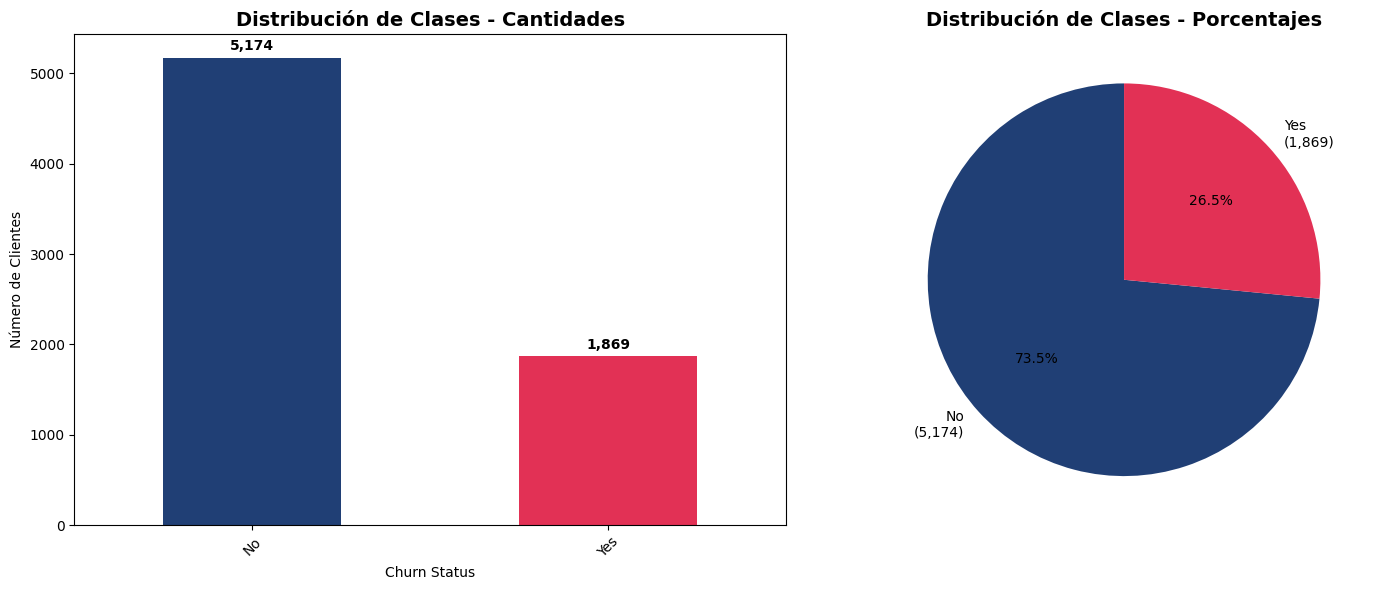

In [34]:
# Visualización de la distribución
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Definir colores personalizados (paleta Zoop)
zoop_colors = ['#203f75', '#e23155']  # Azul para No Churn, Rojo para Churn

# Gráfico de barras
churn_counts.plot(kind='bar', ax=axes[0], color=zoop_colors)
axes[0].set_title('Distribución de Clases - Cantidades', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gráfico de torta
wedges, texts, autotexts = axes[1].pie(churn_counts.values,
                                      labels=[f'{label}\n({count:,})' for label, count in churn_counts.items()],
                                      autopct='%1.1f%%',
                                      colors=zoop_colors,
                                      startangle=90)
axes[1].set_title('Distribución de Clases - Porcentajes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Guardar información para uso posterior
class_distribution = {
    'counts': churn_counts.to_dict(),
    'proportions': churn_proportions.to_dict(),
    'imbalance_ratio': imbalance_ratio,
    'needs_balancing': imbalance_ratio > 2.0
}

## 🔧 Preparación de Variables para Machine Learning

In [35]:
# Preparación de datos para Machine Learning
print("Preparación de las variable para ML")
print("=" * 60)

# Crear copia del dataset para ML
df_ml = df.copy()

print(" Información inicial del dataset:")
print(f"   Dimensiones: {df_ml.shape}")
print(f"   Columnas originales: {len(df_ml.columns)}")

Preparación de las variable para ML
 Información inicial del dataset:
   Dimensiones: (7043, 21)
   Columnas originales: 21


In [36]:
# 1. Eliminar columnas irrelevantes
print("\n Eliminando columnas irrelevantes")
columns_to_drop = ['customerID']  # ID no aporta valor predictivo

df_ml = df_ml.drop(columns=columns_to_drop)
print(f"   Columnas eliminadas: {columns_to_drop}")
print(f"   Dimensiones después: {df_ml.shape}")


 Eliminando columnas irrelevantes
   Columnas eliminadas: ['customerID']
   Dimensiones después: (7043, 20)


In [37]:
# 2. Tipos de variables
print("\n Identificando tipos de variables")

# Variables categóricas binarias (Yes/No)
binary_categorical = []
for col in df_ml.columns:
    if col != 'Churn' and df_ml[col].nunique() == 2:
        unique_vals = df_ml[col].unique()
        if 'Yes' in unique_vals and 'No' in unique_vals:
            binary_categorical.append(col)

# Variables categóricas múltiples
multi_categorical = []
for col in df_ml.columns:
    if col not in binary_categorical and col != 'Churn' and df_ml[col].dtype == 'object':
        multi_categorical.append(col)

# Variables numéricas
numeric_variables = df_ml.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' in numeric_variables:
    numeric_variables.remove('Churn')

print(f"   Variables binarias (Yes/No): {len(binary_categorical)}")
print(f"      {binary_categorical}")
print(f"   Variables categóricas múltiples: {len(multi_categorical)}")
print(f"      {multi_categorical}")
print(f"   Variables numéricas: {len(numeric_variables)}")
print(f"      {numeric_variables}")


 Identificando tipos de variables
   Variables binarias (Yes/No): 4
      ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
   Variables categóricas múltiples: 11
      ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
   Variables numéricas: 4
      ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [38]:
# 3. Codificación de variables categorias
print("\n Codificando variables categóricas")

# Codificar variable objetivo (Churn)
label_encoder = LabelEncoder()
df_ml['Churn'] = label_encoder.fit_transform(df_ml['Churn'])
print(f"   Variable objetivo codificada: No=0, Yes=1")

# Codificar variables binarias Yes/No a 1/0
for col in binary_categorical:
    df_ml[col] = df_ml[col].map({'Yes': 1, 'No': 0})
print(f"   Variables binarias codificadas: {len(binary_categorical)}")

# Manejo especial para servicios de internet
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in internet_services:
    if col in df_ml.columns:
        # Mapear: Yes=1, No=0, No internet service=-1
        df_ml[col] = df_ml[col].map({
            'Yes': 1,
            'No': 0,
            'No internet service': -1
        })

# Mapear MultipleLines
if 'MultipleLines' in df_ml.columns:
    df_ml['MultipleLines'] = df_ml['MultipleLines'].map({
        'Yes': 1,
        'No': 0,
        'No phone service': -1
    })

print(f"   Servicios de internet codificados con mapeo especial")

# One-Hot Encoding para variables categóricas múltiples
df_encoded = df_ml.copy()
categorical_features = []

for col in multi_categorical:
    # Crear variables dummy
    dummies = pd.get_dummies(df_ml[col], prefix=col)
    df_encoded = pd.concat([df_encoded, dummies], axis=1)
    df_encoded = df_encoded.drop(columns=[col])
    categorical_features.extend(dummies.columns.tolist())

print(f"   One-hot encoding aplicado a {len(multi_categorical)} variables")
print(f"   Variables dummy creadas: {len(categorical_features)}")


 Codificando variables categóricas
   Variable objetivo codificada: No=0, Yes=1
   Variables binarias codificadas: 4
   Servicios de internet codificados con mapeo especial
   One-hot encoding aplicado a 11 variables
   Variables dummy creadas: 33


In [39]:
# 4. Verficación final
print(f"\n Preparación completada")
print(f"   Dimensiones finales: {df_encoded.shape}")
print(f"   Variables features: {len(df_encoded.columns) - 1}")
print(f"   Variable objetivo: Churn (0/1)")

# Mostrar información del dataset final
print(f"\n Información del dataset preparado:")
print(f"   Variables numéricas originales: {len(numeric_variables)}")
print(f"   Variables binarias codificadas: {len(binary_categorical) + len(internet_services) + (1 if 'MultipleLines' in df_ml.columns else 0)}")
print(f"   Variables dummy creadas: {len(categorical_features)}")
print(f"   Total features: {len(df_encoded.columns) - 1}")

# Verificar valores faltantes
missing_values = df_encoded.isnull().sum().sum()
print(f"   Valores faltantes: {missing_values}")

if missing_values == 0:
    print("    No hay valores faltantes")
else:
    print("    Hay valores faltantes que necesitan tratamiento")

# Guardar el dataset preparado
df_final = df_encoded.copy()
print(f"\n Dataset preparado guardado como 'df_final'")

# Mostrar ejemplo de las primeras filas
print(f"\n Primeras 3 filas del dataset preparado:")
display(df_final.head(3))


 Preparación completada
   Dimensiones finales: (7043, 42)
   Variables features: 41
   Variable objetivo: Churn (0/1)

 Información del dataset preparado:
   Variables numéricas originales: 4
   Variables binarias codificadas: 11
   Variables dummy creadas: 33
   Total features: 41
   Valores faltantes: 0
    No hay valores faltantes

 Dataset preparado guardado como 'df_final'

 Primeras 3 filas del dataset preparado:


,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Female,gender_Male,MultipleLines_-1,MultipleLines_0,MultipleLines_1,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_-1,OnlineSecurity_0,OnlineSecurity_1,OnlineBackup_-1,OnlineBackup_0,OnlineBackup_1,DeviceProtection_-1,DeviceProtection_0,DeviceProtection_1,TechSupport_-1,TechSupport_0,TechSupport_1,StreamingTV_-1,StreamingTV_0,StreamingTV_1,StreamingMovies_-1,StreamingMovies_0,StreamingMovies_1,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,9,1,1,65.6,593.30,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True
1,0,0,0,0,9,1,0,59.9,542.40,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,True,False,False,False,False,False,True
2,1,0,0,0,4,1,1,73.9,280.85,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False


## 📊 Análisis de Correlación de Variables

In [40]:
# Análisis de correlación de variables
print(" Análisis de correlación de variables")
print("=" * 50)

# Calcular matriz de correlación
correlation_matrix = df_final.corr()

# Análisis de correlación con la variable objetivo (Churn)
churn_correlations = correlation_matrix['Churn'].sort_values(key=abs, ascending=False)

print(" Correlaciones con Churn (ordenadas por valor absoluto):")
print("-" * 50)

# Mostrar las 15 correlaciones más fuertes
top_correlations = churn_correlations.drop('Churn').head(15)  # Excluir autocorrelación

for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    direction = "positiva" if corr > 0 else "negativa"
    strength = "Fuerte" if abs(corr) > 0.3 else "Moderada" if abs(corr) > 0.1 else "Débil"
    print(f"{i:2d}. {feature:<25} {corr:+.4f} ({strength} {direction})")

# Identificar correlaciones más relevantes
strong_positive = churn_correlations[(churn_correlations > 0.2) & (churn_correlations.index != 'Churn')]
strong_negative = churn_correlations[(churn_correlations < -0.2) & (churn_correlations.index != 'Churn')]

print(f"\n Correlaciones positivas fuertes (>0.2): {len(strong_positive)}")
for feature, corr in strong_positive.items():
    print(f"   • {feature}: {corr:+.4f}")

print(f"\n Correlaciones negativas fuertes (<-0.2): {len(strong_negative)}")
for feature, corr in strong_negative.items():
    print(f"   • {feature}: {corr:+.4f}")


 Análisis de correlación de variables
 Correlaciones con Churn (ordenadas por valor absoluto):
--------------------------------------------------
 1. Contract_Month-to-month   +0.4051 (Fuerte positiva)
 2. tenure                    -0.3522 (Fuerte negativa)
 3. OnlineSecurity_0          +0.3426 (Fuerte positiva)
 4. TechSupport_0             +0.3373 (Fuerte positiva)
 5. InternetService_Fiber optic +0.3080 (Fuerte positiva)
 6. Contract_Two year         -0.3023 (Fuerte negativa)
 7. PaymentMethod_Electronic check +0.3019 (Fuerte positiva)
 8. OnlineBackup_0            +0.2680 (Moderada positiva)
 9. DeviceProtection_0        +0.2525 (Moderada positiva)
10. OnlineBackup_-1           -0.2279 (Moderada negativa)
11. StreamingMovies_-1        -0.2279 (Moderada negativa)
12. TechSupport_-1            -0.2279 (Moderada negativa)
13. StreamingTV_-1            -0.2279 (Moderada negativa)
14. OnlineSecurity_-1         -0.2279 (Moderada negativa)
15. InternetService_No        -0.2279 (Moderada n

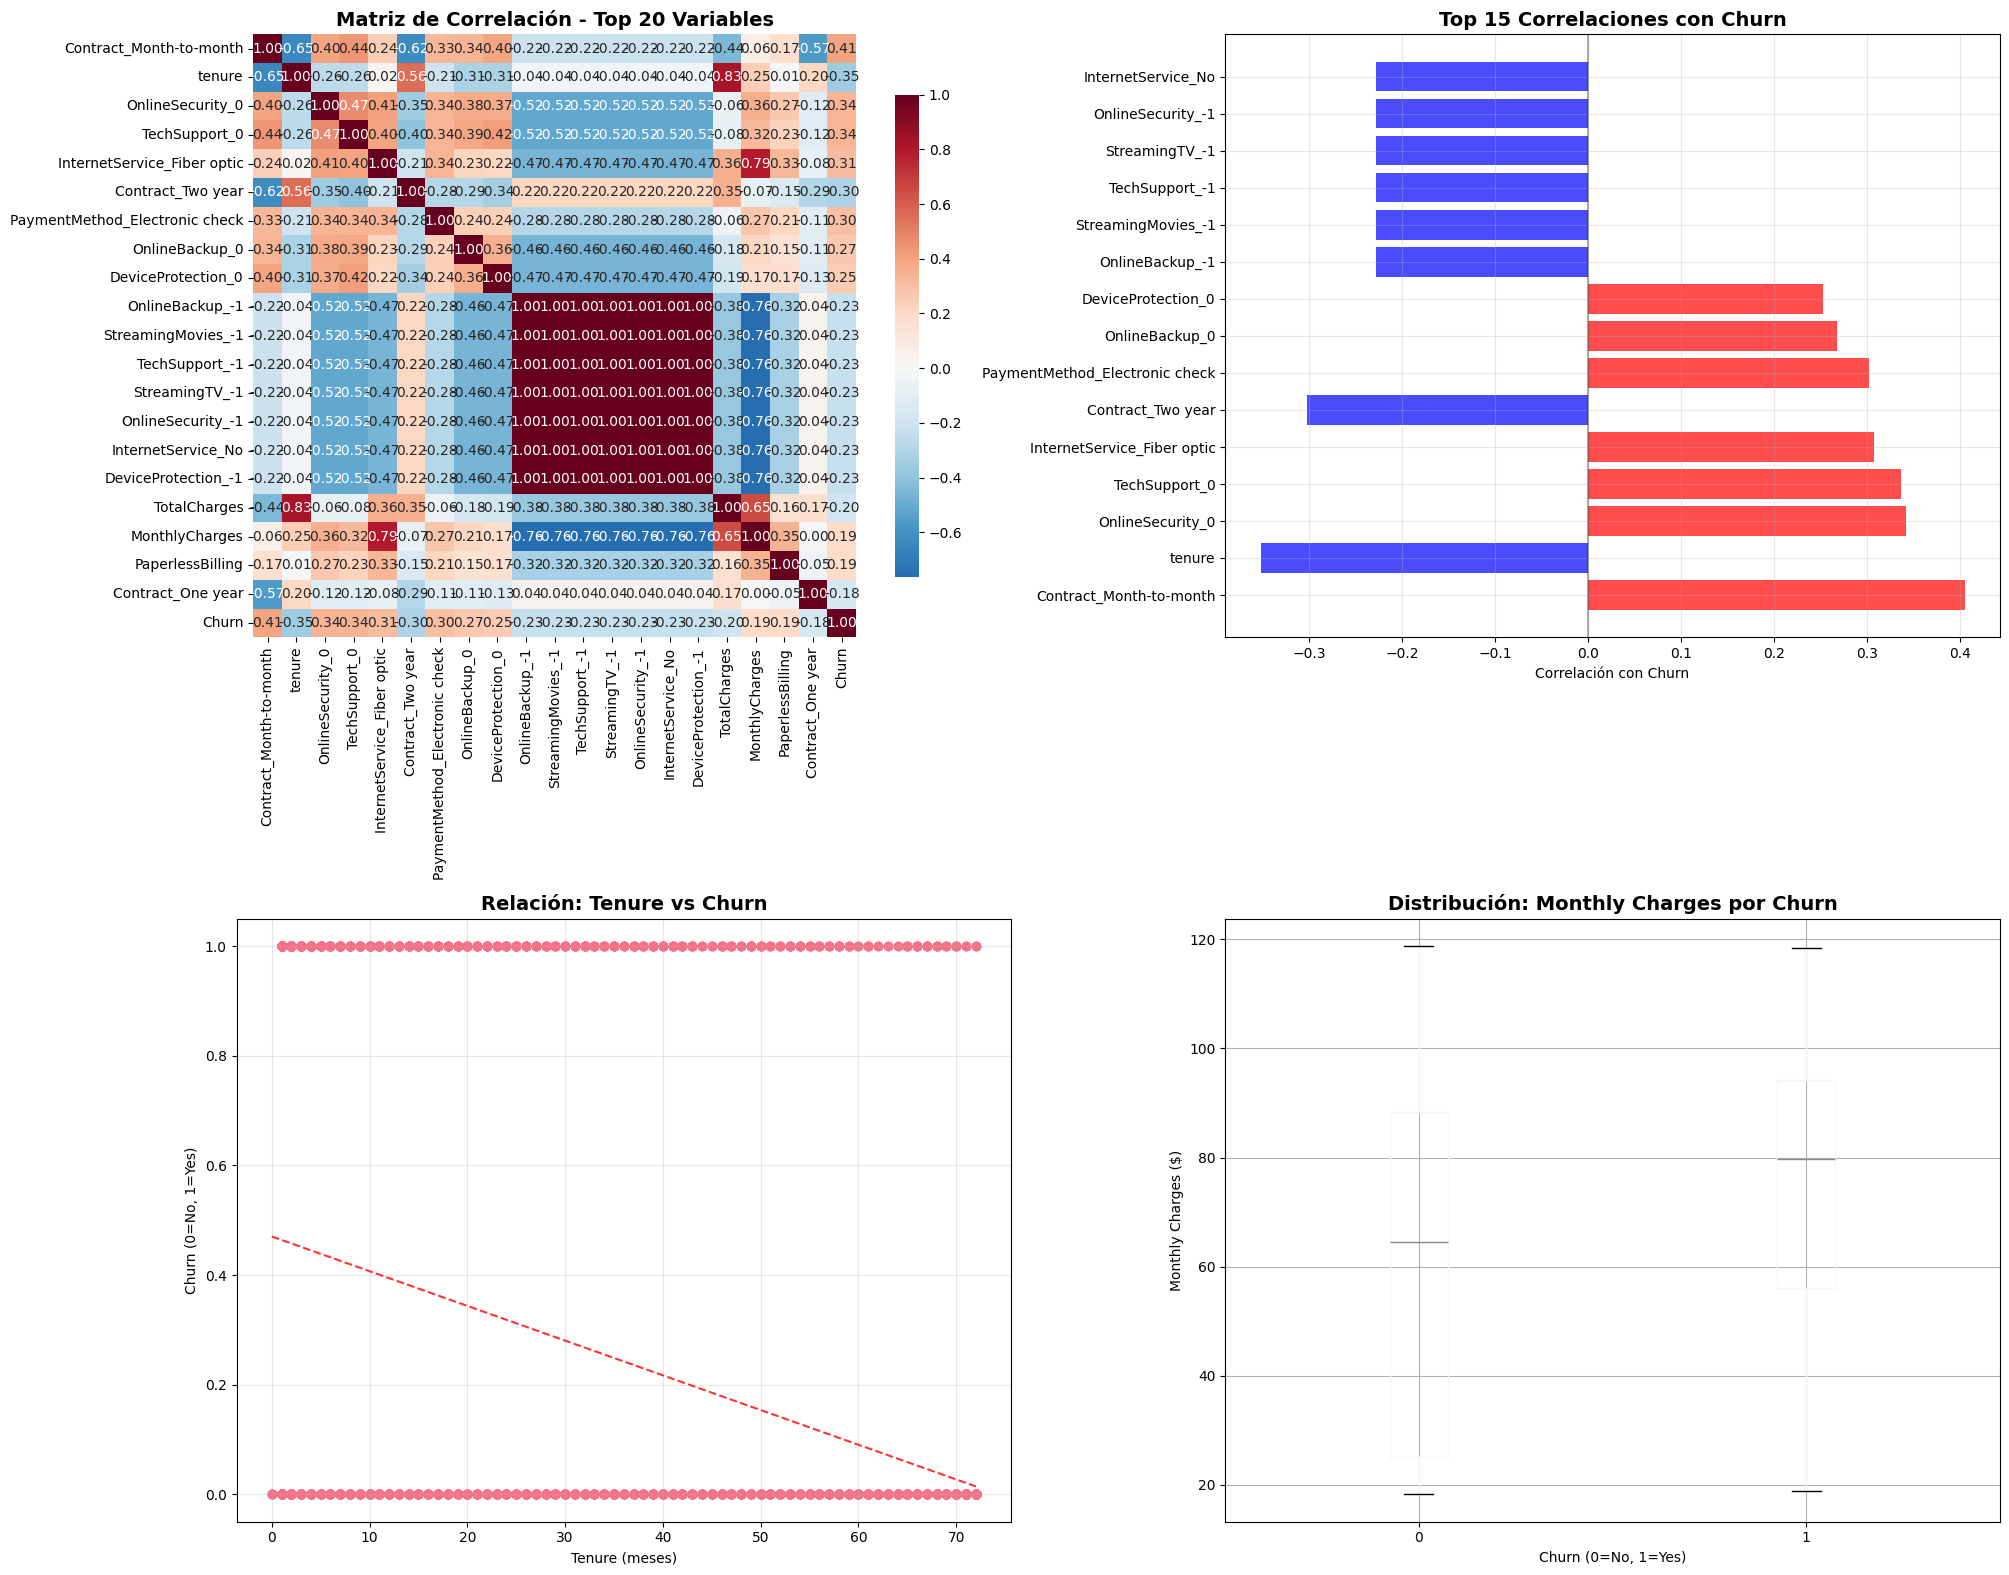

In [46]:
# Visualización de correlaciones
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Heatmap completo de correlaciones (muestra solo subset por legibilidad)
# Seleccionar las variables más correlacionadas para visualización
top_features = churn_correlations.drop('Churn').head(20).index.tolist() + ['Churn']
correlation_subset = df_final[top_features].corr()

sns.heatmap(correlation_subset,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8},
            ax=axes[0,0])
axes[0,0].set_title('Matriz de Correlación - Top 20 Variables', fontsize=14, fontweight='bold')

# 2. Gráfico de barras con correlaciones de Churn
top_15 = churn_correlations.drop('Churn').head(15)
colors = ['red' if x > 0 else 'blue' for x in top_15.values]

axes[0,1].barh(range(len(top_15)), top_15.values, color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(top_15)))
axes[0,1].set_yticklabels(top_15.index, fontsize=10)
axes[0,1].set_xlabel('Correlación con Churn')
axes[0,1].set_title('Top 15 Correlaciones con Churn', fontsize=14, fontweight='bold')
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[0,1].grid(True, alpha=0.3)

# 3. Scatter plot: Tenure vs Churn
axes[1,0].scatter(df_final['tenure'], df_final['Churn'], alpha=0.5)
axes[1,0].set_xlabel('Tenure (meses)')
axes[1,0].set_ylabel('Churn (0=No, 1=Yes)')
axes[1,0].set_title('Relación: Tenure vs Churn', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(df_final['tenure'], df_final['Churn'], 1)
p = np.poly1d(z)
axes[1,0].plot(df_final['tenure'].sort_values(), p(df_final['tenure'].sort_values()), "r--", alpha=0.8)

# 4. Box plot: MonthlyCharges vs Churn
df_final.boxplot(column='MonthlyCharges', by='Churn', ax=axes[1,1])
axes[1,1].set_xlabel('Churn (0=No, 1=Yes)')
axes[1,1].set_ylabel('Monthly Charges ($)')
axes[1,1].set_title('Distribución: Monthly Charges por Churn', fontsize=14, fontweight='bold')

plt.suptitle('')  # Remover título automático del boxplot
plt.tight_layout()
plt.show()

In [48]:
# Análisis de multicolinealidad entre features
print("\n Análisis de multicolinealidad entre features:")
print("-" * 50)

# Encontrar pares de features con alta correlación (excluyendo Churn)
features_only = df_final.drop('Churn', axis=1)
feature_corr = features_only.corr()

# Crear matriz triangular superior para evitar duplicados
upper_triangle = feature_corr.where(
    np.triu(np.ones(feature_corr.shape), k=1).astype(bool)
)

# Encontrar correlaciones altas entre features
high_corr_pairs = []
for col in upper_triangle.columns:
    for row in upper_triangle.index:
        value = upper_triangle.loc[row, col]
        if pd.notna(value) and abs(value) > 0.7:
            high_corr_pairs.append((row, col, value))

if high_corr_pairs:
    print(" Pares de variables con alta correlación (|r| > 0.7):")
    for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   • {var1} ↔ {var2}: {corr:+.4f}")
    print("\n Considerar eliminación de variables redundantes para evitar multicolinealidad")
else:
    print(" No se detectaron correlaciones altas entre features (|r| > 0.7)")

# Selección de features más relevantes para el modelo
print(f"\n Features más relevantes para predicción:")
print("-" * 50)

# Criterio: correlación absoluta > 0.1 con Churn
relevant_features = churn_correlations[
    (abs(churn_correlations) > 0.1) &
    (churn_correlations.index != 'Churn')
].index.tolist()

print(f"Features seleccionadas (|correlación| > 0.1): {len(relevant_features)}")
for i, feature in enumerate(relevant_features[:20], 1):  # Mostrar top 20
    corr = churn_correlations[feature]
    print(f"{i:2d}. {feature:<25} ({corr:+.4f})")

if len(relevant_features) > 20:
    print(f"... y {len(relevant_features) - 20} features adicionales")

# Guardar features relevantes para el modelado
selected_features = relevant_features
print(f"\n {len(selected_features)} features relevantes guardadas para modelado")

# Resumen estadístico de correlaciones
print(f"\n Resumen estadístico de las correlaciones:")
print(f"   Media de correlaciones absolutas: {abs(churn_correlations.drop('Churn')).mean():.4f}")
print(f"   Mediana de correlaciones absolutas: {abs(churn_correlations.drop('Churn')).median():.4f}")
print(f"   Correlación máxima: {churn_correlations.drop('Churn').max():.4f}")
print(f"   Correlación mínima: {churn_correlations.drop('Churn').min():.4f}")
print(f"   Features con correlación > 0.1: {len(relevant_features)}")
print(f"   Features con correlación > 0.2: {len(churn_correlations[(abs(churn_correlations) > 0.2) & (churn_correlations.index != 'Churn')])}")
print(f"   Features con correlación > 0.3: {len(churn_correlations[(abs(churn_correlations) > 0.3) & (churn_correlations.index != 'Churn')])}")


 Análisis de multicolinealidad entre features:
--------------------------------------------------
 Pares de variables con alta correlación (|r| > 0.7):
   • gender_Female ↔ gender_Male: -1.0000
   • PhoneService ↔ MultipleLines_-1: -1.0000
   • InternetService_No ↔ OnlineSecurity_-1: +1.0000
   • InternetService_No ↔ OnlineBackup_-1: +1.0000
   • OnlineSecurity_-1 ↔ OnlineBackup_-1: +1.0000
   • InternetService_No ↔ DeviceProtection_-1: +1.0000
   • OnlineSecurity_-1 ↔ DeviceProtection_-1: +1.0000
   • OnlineBackup_-1 ↔ DeviceProtection_-1: +1.0000
   • InternetService_No ↔ TechSupport_-1: +1.0000
   • OnlineSecurity_-1 ↔ TechSupport_-1: +1.0000
   • OnlineBackup_-1 ↔ TechSupport_-1: +1.0000
   • DeviceProtection_-1 ↔ TechSupport_-1: +1.0000
   • InternetService_No ↔ StreamingTV_-1: +1.0000
   • OnlineSecurity_-1 ↔ StreamingTV_-1: +1.0000
   • OnlineBackup_-1 ↔ StreamingTV_-1: +1.0000
   • DeviceProtection_-1 ↔ StreamingTV_-1: +1.0000
   • TechSupport_-1 ↔ StreamingTV_-1: +1.0000
   •

## 🔀 División de Datos y Normalización